Feature extraction like noise and texture e.t.c

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from scipy.fftpack import fft2, fftshift

def extract_forensic_features(img_path):
    img = cv2.imread(img_path, 0)
    if img is None:
        return None

    img = cv2.resize(img, (512, 512))

    lbp = local_binary_pattern(img, 8, 1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist = hist.astype("float")
    hist = hist / (hist.sum() + 0.0000001)

    f_transform = fft2(img)
    f_shift = fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)
    mean_fft = np.mean(magnitude_spectrum)
    std_fft = np.std(magnitude_spectrum)

    noise_score = cv2.Laplacian(img, cv2.CV_64F).var()

    all_features = np.hstack([hist, [mean_fft, std_fft, noise_score]])
    return all_features

base_path = '/content/drive/MyDrive/TraceFinder_Project/Final_Dataset'
feature_list = []


scanner_folders = sorted(os.listdir(base_path))

for scanner in scanner_folders:
    s_path = os.path.join(base_path, scanner)

    if os.path.isdir(s_path):
        print("Processing scanner: " + scanner)

        all_images = os.listdir(s_path)
        for img_file in all_images:
            file_path = os.path.join(s_path, img_file)

            features = extract_forensic_features(file_path)
            if features is not None:

                row = [scanner] + features.tolist()
                feature_list.append(row)

columns = ['Scanner', 'LBP0', 'LBP1', 'LBP2', 'LBP3', 'LBP4', 'LBP5', 'LBP6', 'LBP7', 'LBP8', 'LBP9', 'FFT_Mean', 'FFT_Std', 'Noise_Var']

df_features = pd.DataFrame(feature_list, columns=columns)

print("Feature Bank Created!")
print("Total rows and columns: ")
print(df_features.shape)
df_features.head()

Processing scanner: Canon120-1
Processing scanner: Canon200
Processing scanner: EpsonV39-1
Processing scanner: EpsonV500
Processing scanner: HP
Feature Bank Created!
Total rows and columns: 
(1348, 14)


,Scanner,LBP0,LBP1,LBP2,LBP3,LBP4,LBP5,LBP6,LBP7,LBP8,LBP9,FFT_Mean,FFT_Std,Noise_Var
0,Canon120-1,0.007065,0.039471,0.009319,0.103687,0.109768,0.273342,0.087845,0.103889,0.170170,0.095444,6.779270,1.680128,249.862789
1,Canon120-1,0.001438,0.011997,0.005455,0.048149,0.073719,0.207939,0.027737,0.069599,0.524918,0.029049,6.865803,1.766399,323.570972
2,Canon120-1,0.001488,0.011345,0.003231,0.071144,0.051628,0.220764,0.022636,0.109043,0.472282,0.036438,6.688713,1.750462,284.745060
3,Canon120-1,0.003891,0.029110,0.007267,0.093040,0.093372,0.271461,0.066460,0.104851,0.248974,0.081573,6.885225,1.711381,310.827148
4,Canon120-1,0.007248,0.040203,0.008923,0.104115,0.102528,0.275154,0.088634,0.105469,0.170696,0.097031,6.795142,1.676834,238.239071


visulization of Noice

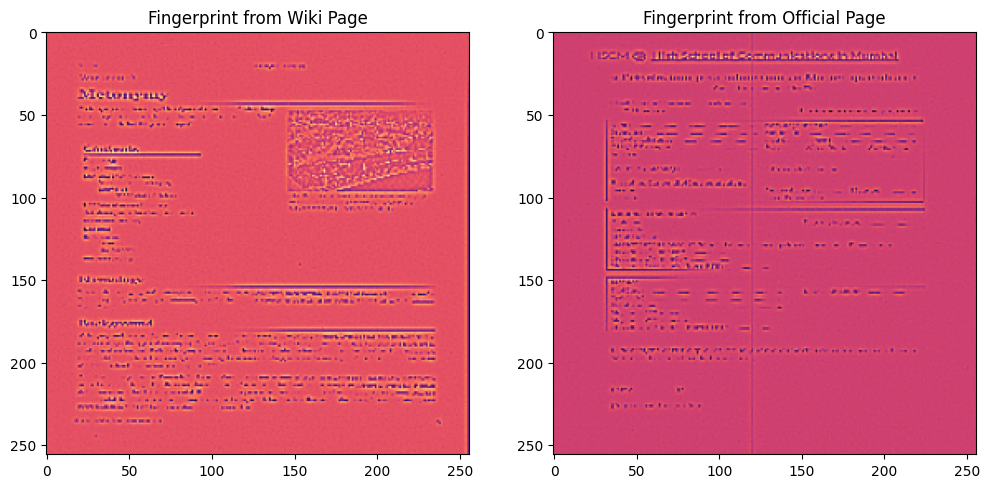

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_noise_map(path):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (256, 256))

    img_float = img.astype(float)

    blurred = cv2.GaussianBlur(img_float, (5,5), 0)

    residual = img_float - blurred

    visible_noise = cv2.normalize(residual, None, 0, 255, cv2.NORM_MINMAX)
    return visible_noise.astype(np.uint8)


all_scanners = os.listdir(base_path)
my_scanner = all_scanners[0]
folder_path = os.path.join(base_path, my_scanner)

files = os.listdir(folder_path)
wiki_path = ""
official_path = ""

for f in files:
    if "set1" in f:
        wiki_path = os.path.join(folder_path, f)
    if "set3" in f:
        official_path = os.path.join(folder_path, f)

map1 = get_noise_map(wiki_path)
map2 = get_noise_map(official_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Fingerprint from Wiki Page")
plt.imshow(map1, cmap='magma')

plt.subplot(1, 2, 2)
plt.title("Fingerprint from Official Page")
plt.imshow(map2, cmap='magma')
plt.show()

Confusion matrix

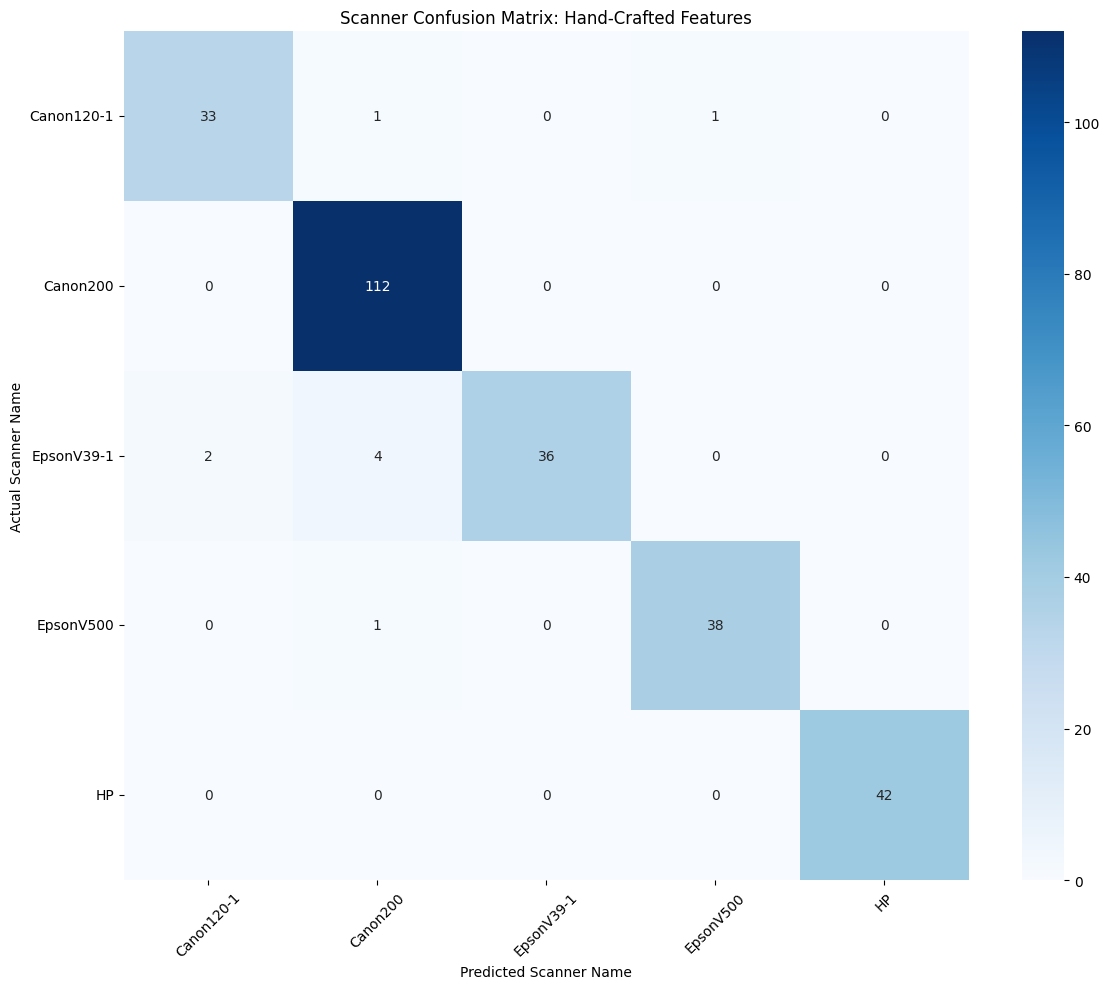

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = sorted(df_features['Scanner'].unique())

y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))

sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Scanner Confusion Matrix: Hand-Crafted Features')
plt.ylabel('Actual Scanner Name')
plt.xlabel('Predicted Scanner Name')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Random Forest training

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = df_features.drop('Scanner', axis=1)
y = df_features['Scanner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print("Random Forest Accuracy: %.2f" % (accuracy_score(y_test, y_pred) * 100))


Random Forest Accuracy: 86.67


SVM Training

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)
print( "SVM Accuracy:  %.2f" % (accuracy_score(y_test, y_pred_svm) * 100))

SVM Accuracy:  79.63


 Logistic Regression

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)

print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Overall Accuracy: 82.22%

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.68      0.71      0.69        35
    Canon200       0.75      0.96      0.84       112
  EpsonV39-1       0.91      0.24      0.38        42
   EpsonV500       1.00      0.97      0.99        39
          HP       1.00      1.00      1.00        42

    accuracy                           0.82       270
   macro avg       0.87      0.78      0.78       270
weighted avg       0.84      0.82      0.80       270

